# Desafío 1 — Análisis de 4 Tiendas (ENTREGA OFICIAL)

**Alumno:** David González  
**Fecha:** 2025-08-14

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Flacoca1970/Desafios_1/blob/main/AluraStoreLatam_Desafio_1_Entrega_Final_v3.ipynb)

> `<Flacoca1970>/<Desafios1>` 

[Ver en GitHub](https://github.com/Flacoca1970/Desafios_1/blob/main/AluraStoreLatam_Desafio_1_Entrega_Final_v3.ipynb)

<a href="https://colab.research.google.com/github/flacoca/Proyecto_Prueba/blob/main/AluraStoreLatam_Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importación de datos



In [1]:
import pandas as pd
import numpy as np
import unicodedata
from collections import OrderedDict
from IPython.display import display

# -- 0) URLs oficiales --
url1 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

# -- 0.1) Garantizar que existen las variables tienda..tienda4 --
try:
    tienda, tienda2, tienda3, tienda4  # type: ignore
except NameError:
    tienda  = pd.read_csv(url1)
    tienda2 = pd.read_csv(url2)
    tienda3 = pd.read_csv(url3)
    tienda4 = pd.read_csv(url4)


tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


In [4]:

# ==========================================#
# UTILIDAD DE CALCULOS DE TODO LO SOLICITADO#
# ==========================================#

def _normalize(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    return s.strip().lower().replace("  ", " ")

def detectar_columnas(df: pd.DataFrame) -> dict:
    norm_map = {col: _normalize(col) for col in df.columns}

    def _find(*cands):
        targets = [_normalize(c) for c in cands]
        # match exact
        for real, normed in norm_map.items():
            if normed in targets:
                return real
        # match contains
        for real, normed in norm_map.items():
            if any(t in normed for t in targets):
                return real
        return None

    cols = {
        "producto":    _find("producto"),
        "categoria":   _find("categoría del producto", "categoria del producto", "categoría", "categoria"),
        "precio":      _find("precio", "valor de venta", "monto"),
        "envio":       _find("costo de envío", "costo de envio", "envío", "envio", "costo envio"),
        "calificacion":_find("calificación", "calificacion", "rating", "puntaje"),
        "fecha":       _find("fecha de compra", "fecha"),
    }
    requeridas = ["producto", "categoria", "precio", "envio", "calificacion"]
    falt = [k for k in requeridas if cols[k] is None]
    if falt:
        raise KeyError(f"Faltan columnas requeridas: {falt}\nDisponibles: {list(df.columns)}")
    return cols

def preparar_tipos(df: pd.DataFrame, cols: dict) -> pd.DataFrame:
    dfx = df.copy()
    for k in ["precio", "envio", "calificacion"]:
        dfx[cols[k]] = pd.to_numeric(dfx[cols[k]], errors="coerce")
    if cols.get("fecha"):
        dfx[cols["fecha"]] = pd.to_datetime(dfx[cols["fecha"]], errors="coerce", dayfirst=True)
    for k in ["producto", "categoria"]:
        dfx[cols[k]] = dfx[cols[k]].astype(str).str.strip()
    return dfx

def analisis_facturacion(df, cols):
    total = df[cols["precio"]].sum(skipna=True)
    n_ventas = df[cols["precio"]].notna().sum()
    ticket_prom = total / n_ventas if n_ventas else np.nan
    return {"Facturacion_Total": total, "N_Ventas": n_ventas, "Ticket_Promedio": ticket_prom}

def ventas_por_categoria(df, cols, top_n=10):
    por_conteo = (
        df.groupby(cols["categoria"], dropna=False)
          .size()
          .sort_values(ascending=False)
          .rename("Conteo")
    )
    por_facturacion = (
        df.groupby(cols["categoria"], dropna=False)[cols["precio"]]
          .sum()
          .sort_values(ascending=False)
          .rename("Facturacion")
    )
    return por_conteo.head(top_n), por_facturacion.head(top_n)

def calificacion_promedio(df, cols):
    return float(df[cols["calificacion"]].mean(skipna=True))

def productos_mas_menos_vendidos(df, cols, k=5):
    vc = df[cols["producto"]].value_counts(dropna=True)
    topk = vc.head(min(k, len(vc)))
    bottomk = vc.tail(min(k, len(vc))) if len(vc) else vc
    return topk, bottomk

def envio_promedio(df, cols):
    return float(df[cols["envio"]].mean(skipna=True))

# =========================
# Análisis en el ORDEN 1–5
# =========================
tiendas = OrderedDict({
    "Tienda 1": tienda,
    "Tienda 2": tienda2,
    "Tienda 3": tienda3,
    "Tienda 4": tienda4,
})

# Detectar columnas y preparar tipos por tienda (sin tocar los DFs originales)
tiendas_ready = OrderedDict()
cols_por_tienda = {}
for nombre, df in tiendas.items():
    cols = detectar_columnas(df)
    dfx = preparar_tipos(df, cols)
    tiendas_ready[nombre] = dfx
    cols_por_tienda[nombre] = cols


#1. Análisis de facturación



In [7]:
from IPython.display import display

def _miles(x):  # 1.234.567
    return f"{int(round(x)):,}".replace(",", ".")

def _clp(x):    # $1.234.567
    return "$" + _miles(x)

# Calculate resumen_facturacion by applying analisis_facturacion to each tienda_ready
rows_fact = []
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    resumen = analisis_facturacion(dfx, cols)
    rows_fact.append({"Tienda": nombre, **resumen})
resumen_facturacion = pd.DataFrame(rows_fact)


print("=== 1) Análisis de facturación ===")
# Mostrar SOLO la tabla formateada
display(
    resumen_facturacion
        .copy()
        .assign(
            Facturacion_Total=lambda d: d["Facturacion_Total"].round(0).map(_clp),
            N_Ventas=lambda d: d["N_Ventas"].round(0).map(_miles),
            Ticket_Promedio=lambda d: d["Ticket_Promedio"].round(0).map(_clp),
        )
)

=== 1) Análisis de facturación ===


,Tienda,Facturacion_Total,N_Ventas,Ticket_Promedio
0,Tienda 1,$1.150.880.400,2.359,$487.868
1,Tienda 2,$1.116.343.500,2.359,$473.227
2,Tienda 3,$1.098.019.600,2.359,$465.460
3,Tienda 4,$1.038.375.700,2.358,$440.363


# 2. Ventas por categoría

In [8]:
# 2) Ventas por categoría
print("\n=== 2) Ventas por categoría (Top 10) ===")
ventas_cat_conteo = {}
ventas_cat_fact = {}
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    conteo, fact = ventas_por_categoria(dfx, cols, top_n=10)
    ventas_cat_conteo[nombre] = conteo
    ventas_cat_fact[nombre] = fact
    print(f"\n-- {nombre} | Top 10 por CONTEO --"); display(conteo)
    print(f"-- {nombre} | Top 10 por FACTURACIÓN --"); display(fact)


=== 2) Ventas por categoría (Top 10) ===

-- Tienda 1 | Top 10 por CONTEO --


,Conteo
Categoría del Producto,
Muebles,465
Electrónicos,448
Juguetes,324
Electrodomésticos,312
Deportes y diversión,284
Instrumentos musicales,182
Libros,173
Artículos para el hogar,171


-- Tienda 1 | Top 10 por FACTURACIÓN --


,Facturacion
Categoría del Producto,
Electrónicos,429493500.0
Electrodomésticos,363685200.0
Muebles,187633700.0
Instrumentos musicales,91299000.0
Deportes y diversión,39290000.0
Juguetes,17995700.0
Artículos para el hogar,12698400.0
Libros,8784900.0



-- Tienda 2 | Top 10 por CONTEO --


,Conteo
Categoría del Producto,
Muebles,442
Electrónicos,422
Juguetes,313
Electrodomésticos,305
Deportes y diversión,275
Instrumentos musicales,224
Libros,197
Artículos para el hogar,181


-- Tienda 2 | Top 10 por FACTURACIÓN --


,Facturacion
Categoría del Producto,
Electrónicos,410831100.0
Electrodomésticos,348567800.0
Muebles,176426300.0
Instrumentos musicales,104990300.0
Deportes y diversión,34744500.0
Juguetes,15945400.0
Artículos para el hogar,14746900.0
Libros,10091200.0



-- Tienda 3 | Top 10 por CONTEO --


,Conteo
Categoría del Producto,
Muebles,499
Electrónicos,451
Juguetes,315
Electrodomésticos,278
Deportes y diversión,277
Libros,185
Artículos para el hogar,177
Instrumentos musicales,177


-- Tienda 3 | Top 10 por FACTURACIÓN --


,Facturacion
Categoría del Producto,
Electrónicos,410775800.0
Electrodomésticos,329237900.0
Muebles,201072100.0
Instrumentos musicales,77380900.0
Deportes y diversión,35593100.0
Juguetes,19401100.0
Artículos para el hogar,15060000.0
Libros,9498700.0



-- Tienda 4 | Top 10 por CONTEO --


,Conteo
Categoría del Producto,
Muebles,480
Electrónicos,451
Juguetes,338
Deportes y diversión,277
Electrodomésticos,254
Artículos para el hogar,201
Libros,187
Instrumentos musicales,170


-- Tienda 4 | Top 10 por FACTURACIÓN --


,Facturacion
Categoría del Producto,
Electrónicos,409476100.0
Electrodomésticos,283260200.0
Muebles,192528900.0
Instrumentos musicales,75102400.0
Deportes y diversión,33350100.0
Juguetes,20262200.0
Artículos para el hogar,15074500.0
Libros,9321300.0


# 3. Calificación promedio de la tienda


In [ ]:
# 3) Calificación promedio de la tienda
print("\n=== 3) Calificación promedio por tienda ===")
rows_calif = []
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    prom = calificacion_promedio(dfx, cols)
    rows_calif.append({"Tienda": nombre, "Calificacion_Promedio": prom})
    print(f"{nombre}: {prom:.2f}")
resumen_calificacion = pd.DataFrame(rows_calif).sort_values("Calificacion_Promedio", ascending=False).reset_index(drop=True)


=== 3) Calificación promedio por tienda ===
Tienda 1: 3.98
Tienda 2: 4.04
Tienda 3: 4.05
Tienda 4: 4.00


# 4. Productos más y menos vendidos

In [ ]:
# 4) Productos más y menos vendidos
print("\n=== 4) Productos más y menos vendidos (frecuencia) ===")
top_bottom = {}
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    top5, bottom5 = productos_mas_menos_vendidos(dfx, cols, k=5)
    top_bottom[nombre] = {"Top5": top5, "Bottom5": bottom5}
    print(f"\n-- {nombre} | TOP 5 --"); display(top5)
    print(f"-- {nombre} | BOTTOM 5 --"); display(bottom5)


=== 4) Productos más y menos vendidos (frecuencia) ===

-- Tienda 1 | TOP 5 --


,count
Producto,
Microondas,60
TV LED UHD 4K,60
Armario,60
Secadora de ropa,58
Mesa de noche,56


-- Tienda 1 | BOTTOM 5 --


,count
Producto,
Ciencia de datos con Python,39
Pandereta,36
Olla de presión,35
Auriculares con micrófono,33
Celular ABXY,33



-- Tienda 2 | TOP 5 --


,count
Producto,
Iniciando en programación,65
Microondas,62
Batería,61
Guitarra acústica,58
Pandereta,58


-- Tienda 2 | BOTTOM 5 --


,count
Producto,
Auriculares,37
Sillón,35
Mesa de comedor,34
Impresora,34
Juego de mesa,32



-- Tienda 3 | TOP 5 --


,count
Producto,
Kit de bancas,57
Mesa de comedor,56
Cama king,56
Set de ollas,55
Mesa de noche,55


-- Tienda 3 | BOTTOM 5 --


,count
Producto,
Guitarra eléctrica,38
Set de vasos,36
Mochila,36
Microondas,36
Bloques de construcción,35



-- Tienda 4 | TOP 5 --


,count
Producto,
Cama box,62
Cubertería,59
Dashboards con Power BI,56
Cama king,56
Carrito de control remoto,55


-- Tienda 4 | BOTTOM 5 --


,count
Producto,
Refrigerador,38
Ciencia de datos con Python,38
Guitarra acústica,37
Armario,34
Guitarra eléctrica,33


# 5. Envío promedio por tienda

In [ ]:
# 5) Envío promedio por tienda
print("\n=== 5) Envío promedio por tienda ===")
rows_envio = []
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    prom_envio = envio_promedio(dfx, cols)
    rows_envio.append({"Tienda": nombre, "Costo_Envio_Promedio": prom_envio})
    print(f"{nombre}: {prom_envio:.2f}")
resumen_envio = pd.DataFrame(rows_envio).sort_values("Costo_Envio_Promedio").reset_index(drop=True)

# Resúmenes clave
print("\n=== Resúmenes clave ===")
display(resumen_facturacion)
display(resumen_calificacion)
display(resumen_envio)


=== 5) Envío promedio por tienda ===
Tienda 1: 26018.61
Tienda 2: 25216.24
Tienda 3: 24805.68
Tienda 4: 23459.46

=== Resúmenes clave ===


,Tienda,Facturacion_Total,N_Ventas,Ticket_Promedio
0,Tienda 1,1.150880e+09,2359,487867.910131
1,Tienda 2,1.116344e+09,2359,473227.426876
2,Tienda 3,1.098020e+09,2359,465459.771089
3,Tienda 4,1.038376e+09,2358,440362.892282


,Tienda,Calificacion_Promedio
0,Tienda 3,4.048326
1,Tienda 2,4.037304
2,Tienda 4,3.995759
3,Tienda 1,3.976685


,Tienda,Costo_Envio_Promedio
0,Tienda 4,23459.457167
1,Tienda 3,24805.680373
2,Tienda 2,25216.235693
3,Tienda 1,26018.609580


# ANEXO — Desarrollo extendido (1–9)

> Estas celdas se mantienen como **anexo**. La **entrega oficial** está al final del notebook en la sección **ENTREGA OFICIAL (1–5)**.

# Proyecto: Análisis de Tiendas del Sr. Juan
**Objetivo:** Determinar qué tienda vender para financiar un nuevo negocio, usando métricas de desempeño y satisfacción de clientes.

> **Nota:** Estas celdas usan los `DataFrame` ya existentes: `store1`, `store2`, `store3`, `store4`.

## 1) Importaciones y verificación de datos cargados

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verificación rápida de existencia de los DataFrames esperados
expected_names = ['store1', 'store2', 'store3', 'store4']
missing = [name for name in expected_names if name not in globals()]
print("DataFrames faltantes:", missing if missing else "OK — todos los DataFrames están disponibles.")


DataFrames faltantes: ['store1', 'store2', 'store3', 'store4']


## 2) Exploración inicial (EDA básico)

In [ ]:
stores = [tienda.copy(), tienda2.copy(), tienda3.copy(), tienda4.copy()]
for i, df in enumerate(stores, start=1):
    print(f"\n=== Tienda {i} ===")
    print(df.head(3))
    print("\nTipos de datos:")
    print(df.dtypes)
    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


=== Tienda 1 ===
            Producto Categoría del Producto    Precio  Costo de envío  \
0  Asistente virtual           Electrónicos  164300.0          6900.0   
1    Mesa de comedor                Muebles  192300.0          8400.0   
2      Juego de mesa               Juguetes  209600.0         15900.0   

  Fecha de Compra         Vendedor Lugar de Compra  Calificación  \
0      16/01/2021      Pedro Gomez          Bogotá             4   
1      18/05/2022  Beatriz Morales        Medellín             1   
2      15/03/2021   Juan Fernandez       Cartagena             1   

       Método de pago  Cantidad de cuotas       lat       lon  
0  Tarjeta de crédito                   8   4.60971 -74.08175  
1  Tarjeta de crédito                   4   6.25184 -75.56359  
2  Tarjeta de crédito                   1  10.39972 -75.51444  

Tipos de datos:
Producto                   object
Categoría del Producto     object
Precio                    float64
Costo de envío            float64
Fecha d

## 3) Facturación total por tienda

In [ ]:
def facturacion_por_tienda(df):
    # Asumimos que `Precio` representa el valor de venta unitario por fila/compra
    return df['Precio'].sum()

facturacion = {
    'Tienda 1': facturacion_por_tienda(tienda),
    'Tienda 2': facturacion_por_tienda(tienda2),
    'Tienda 3': facturacion_por_tienda(tienda3),
    'Tienda 4': facturacion_por_tienda(tienda4)
}

facturacion_df = pd.DataFrame.from_dict(facturacion, orient='index', columns=['Facturación_Total']).sort_values('Facturación_Total', ascending=False)
facturacion_df

,Facturación_Total
Tienda 1,1.150880e+09
Tienda 2,1.116344e+09
Tienda 3,1.098020e+09
Tienda 4,1.038376e+09


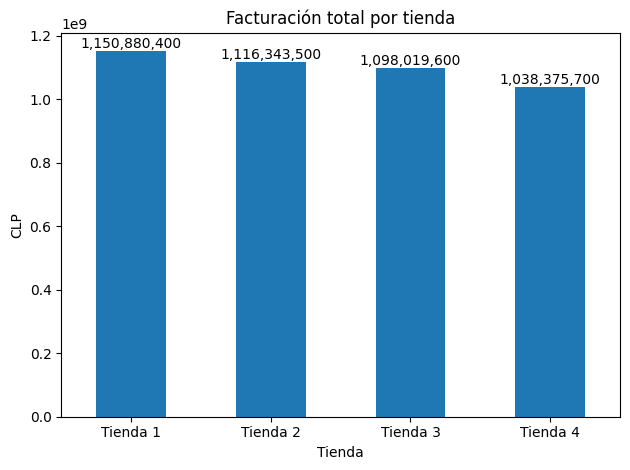

In [ ]:
# Graficamos la facturaciòn total por tienda para visualizarla de  mejor manera

import matplotlib.pyplot as plt

ax = facturacion_df.plot(kind='bar', y='Facturación_Total', legend=False)
ax.set_title('Facturación total por tienda')
ax.set_xlabel('Tienda')
ax.set_ylabel('CLP')
ax.set_xticklabels(facturacion_df.index, rotation=0)

# Etiquetas con el valor en cada barra (formato con miles)
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')

plt.tight_layout()
plt.show()

# (Opcional) Guardar
# plt.savefig('outputs/facturacion_total.png', bbox_inches='tight')


## 4) Categorías más populares (Top 5 por tienda)

In [ ]:

def categorias_populares(df, top=5):
    return df['Categoría del Producto'].value_counts().head(top)

categorias_top = {}
for i, df in enumerate(stores, start=1):
    categorias_top[f'Tienda {i}'] = categorias_populares(df)

# Mostrar resultado como tabla consolidada (categoría y conteo por tienda)
# Se construye una tabla con MultiIndex para facilitar lectura
cat_tables = []
for i, df in enumerate(stores, start=1):
    ct = df['Categoría del Producto'].value_counts().head(5).rename(f'Tienda {i}')
    cat_tables.append(ct)

categorias_consolidado = pd.concat(cat_tables, axis=1)
categorias_consolidado.fillna(0).astype(int)


,Tienda 1,Tienda 2,Tienda 3,Tienda 4
Categoría del Producto,,,,
Muebles,465,442,499,480
Electrónicos,448,422,451,451
Juguetes,324,313,315,338
Electrodomésticos,312,305,278,254
Deportes y diversión,284,275,277,277


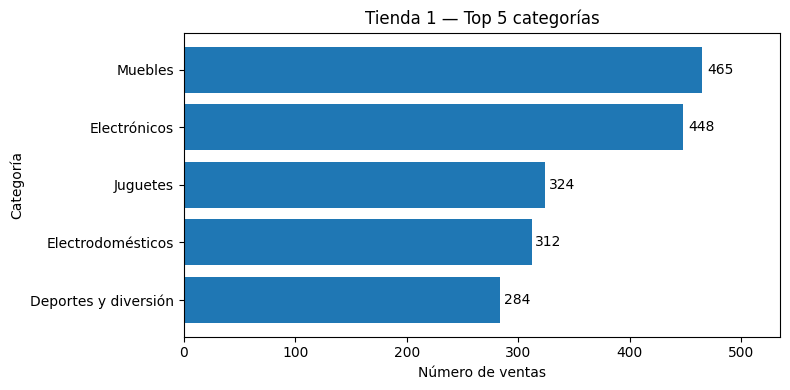

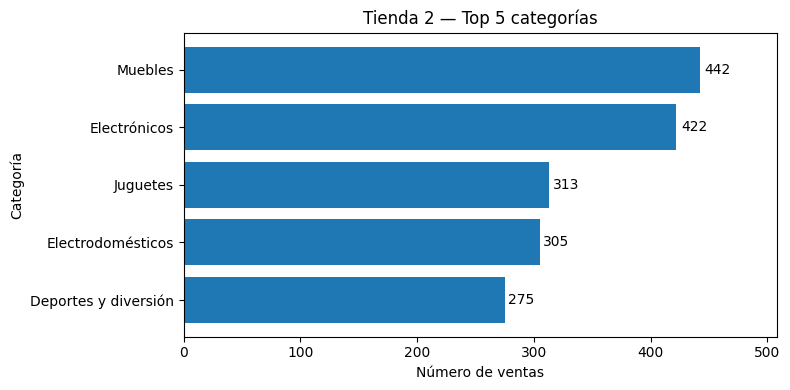

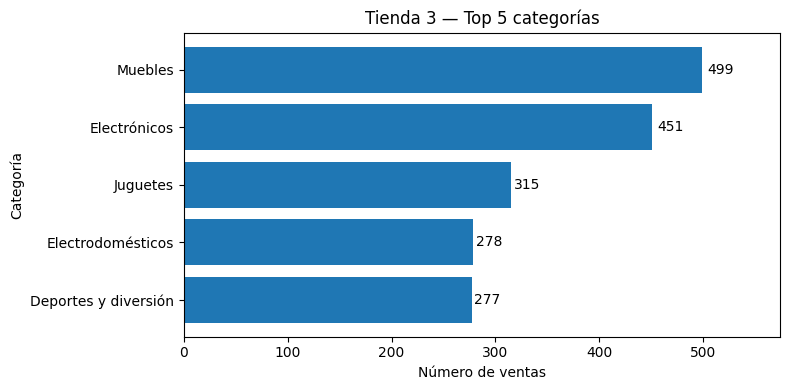

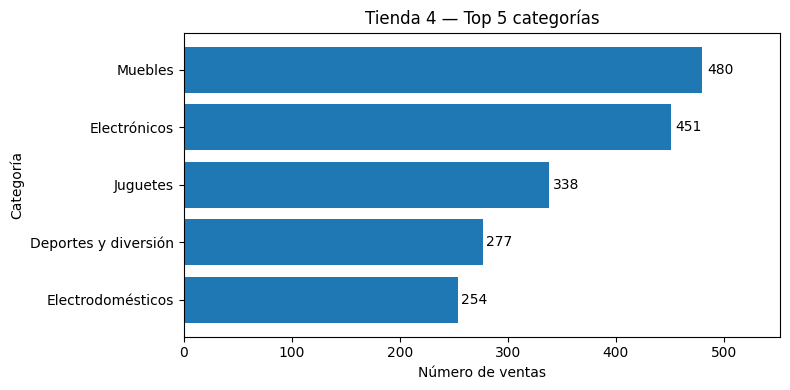

In [ ]:
# Se grafican las categorias top 5 por cada tienda para visualizarlas de forma más simple
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Usa tus DFs ya cargados; si no existe 'stores', lo armamos
try:
    stores
except NameError:
    stores = [tienda, tienda2, tienda3, tienda4]

def miles_fmt(x, pos):
    try:
        return f"{int(x):,}".replace(",", ".")
    except Exception:
        return x

def plot_top5_categorias(df, i, save=False):
    # Top 5 categorías ordenadas asc para barh
    top5 = (
        df['Categoría del Producto']
          .astype(str).str.strip()
          .value_counts()
          .head(5)
          .sort_values()
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.barh(top5.index, top5.values)

    # Espacio a la derecha para que quepan las etiquetas
    max_val = top5.values.max() if len(top5) else 0
    ax.set_xlim(0, max_val * 1.15)

    # Etiquetas fuera de la barra
    for bar, val in zip(bars, top5.values):
        ax.text(val * 1.01, bar.get_y() + bar.get_height()/2,
                f"{val:,}".replace(",", "."),
                va="center", fontsize=10)

    ax.set_title(f"Tienda {i} — Top 5 categorías")
    ax.set_xlabel("Número de ventas")
    ax.set_ylabel("Categoría")
    ax.xaxis.set_major_formatter(FuncFormatter(miles_fmt))

    plt.tight_layout()
    if save:
        plt.savefig(f"outputs/tienda_{i}_categorias_top5.png", bbox_inches="tight")
    plt.show()

# Genera un gráfico por tienda
for i, df in enumerate(stores, start=1):
    plot_top5_categorias(df, i, save=False)





## 5) Promedio de calificación de clientes

In [ ]:

promedios_calificacion = {
    f'Tienda {i}': df['Calificación'].mean()
    for i, df in enumerate(stores, start=1)
}
promedios_calificacion_df = pd.DataFrame.from_dict(promedios_calificacion, orient='index', columns=['Calificación_Promedio']).sort_values('Calificación_Promedio', ascending=False)
promedios_calificacion_df


,Calificación_Promedio
Tienda 3,4.048326
Tienda 2,4.037304
Tienda 4,3.995759
Tienda 1,3.976685


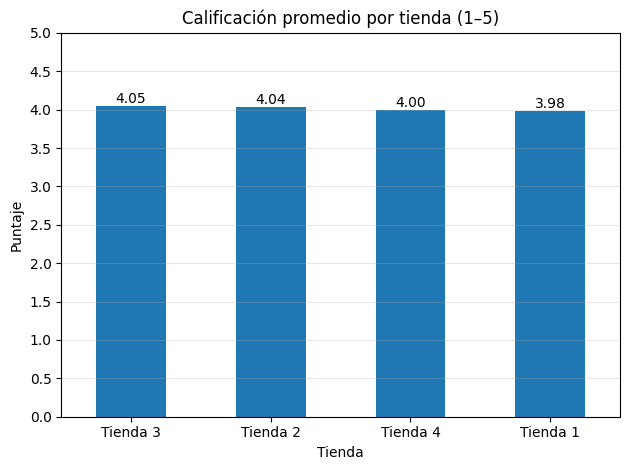

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

# Si no existe el DF, lo calculamos desde 'stores'
try:
    promedios_calificacion_df
except NameError:
    promedios_calificacion = {
        f'Tienda {i}': df['Calificación'].mean()
        for i, df in enumerate(stores, start=1)
    }
    promedios_calificacion_df = pd.DataFrame.from_dict(
        promedios_calificacion, orient='index',
        columns=['Calificación_Promedio']
    ).sort_values('Calificación_Promedio', ascending=False)

# --- Gráfico de barras (vertical) ---
fig, ax = plt.subplots()
promedios_calificacion_df.plot(
    kind='bar', y='Calificación_Promedio', legend=False, ax=ax
)

ax.set_title('Calificación promedio por tienda (1–5)')
ax.set_xlabel('Tienda')
ax.set_ylabel('Puntaje')
ax.set_ylim(0, 5)                       # fija escala 0–5
ax.set_xticklabels(promedios_calificacion_df.index, rotation=0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.grid(axis='y', alpha=0.3)

# Etiquetas con dos decimales encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

# (Opcional) Guardar
# plt.savefig('outputs/calificacion_promedio.png', bbox_inches='tight')


## 6) Productos más y menos vendidos (Top/Bottom 5)

In [ ]:

def extremos_ventas(df, top=5):
    vc = df['Producto'].value_counts()
    return vc.head(top), vc.tail(top)

extremos = {}
for i, df in enumerate(stores, start=1):
    top5, bottom5 = extremos_ventas(df, top=5)
    extremos[f'Tienda {i}'] = {'Top_5': top5, 'Bottom_5': bottom5}

# Mostrar de forma legible
for tienda, datos in extremos.items():
    print(f"\n{tienda} — Top 5 más vendidos:")
    print(datos['Top_5'])
    print(f"\n{tienda} — Bottom 5 menos vendidos:")
    print(datos['Bottom_5'])



Tienda 1 — Top 5 más vendidos:
Producto
Microondas          60
TV LED UHD 4K       60
Armario             60
Secadora de ropa    58
Mesa de noche       56
Name: count, dtype: int64

Tienda 1 — Bottom 5 menos vendidos:
Producto
Ciencia de datos con Python    39
Pandereta                      36
Olla de presión                35
Auriculares con micrófono      33
Celular ABXY                   33
Name: count, dtype: int64

Tienda 2 — Top 5 más vendidos:
Producto
Iniciando en programación    65
Microondas                   62
Batería                      61
Guitarra acústica            58
Pandereta                    58
Name: count, dtype: int64

Tienda 2 — Bottom 5 menos vendidos:
Producto
Auriculares        37
Sillón             35
Mesa de comedor    34
Impresora          34
Juego de mesa      32
Name: count, dtype: int64

Tienda 3 — Top 5 más vendidos:
Producto
Kit de bancas      57
Mesa de comedor    56
Cama king          56
Set de ollas       55
Mesa de noche      55
Name: count, dty

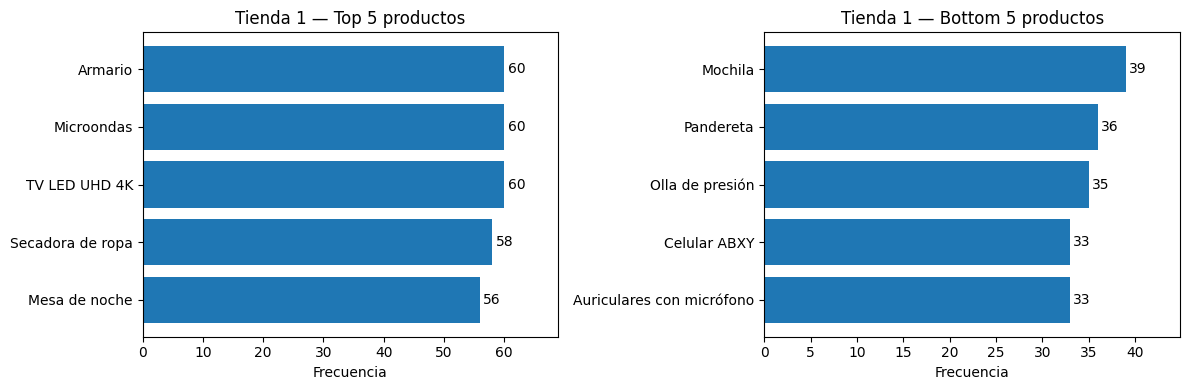

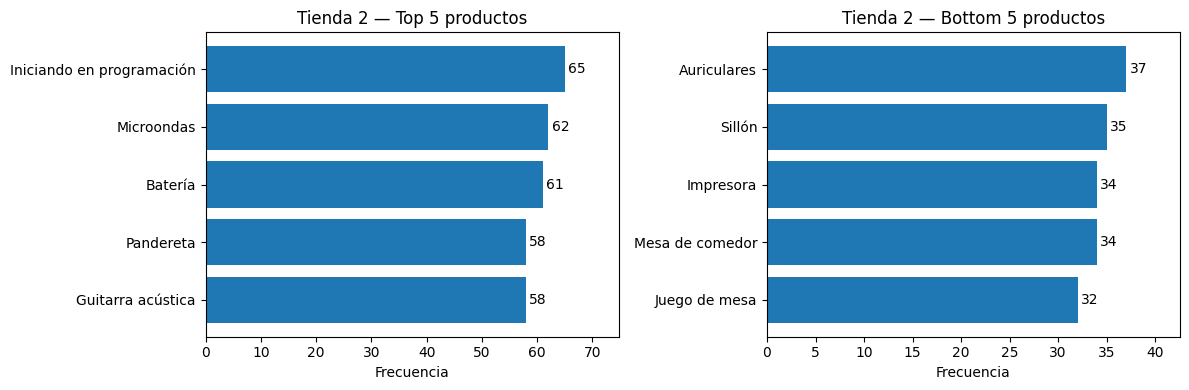

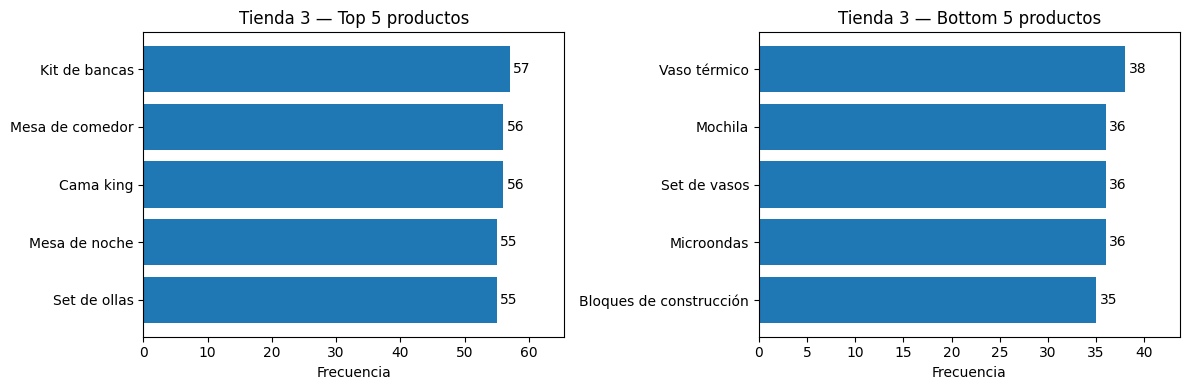

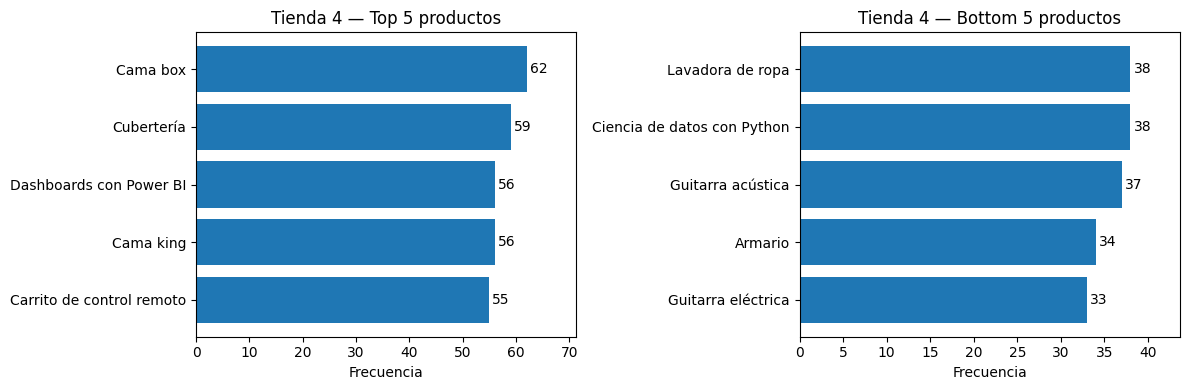

In [ ]:
import os
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt

# --- Helpers robustos ---
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    return "".join(c for c in s if not unicodedata.combining(c)).strip().lower()

def _get_four_dfs():
    # 1) Usa 'stores' si existe
    if 'stores' in globals():
        return stores
    # 2) Usa tienda..tienda4 si existen
    if all(n in globals() for n in ("tienda","tienda2","tienda3","tienda4")):
        return [tienda, tienda2, tienda3, tienda4]
    # 3) O falla explícitamente
    raise NameError("No encuentro 'stores' ni (tienda, tienda2, tienda3, tienda4) en memoria.")

def _find_product_col(df: pd.DataFrame) -> str:
    if "Producto" in df.columns:
        return "Producto"
    nm = {col: _norm(col) for col in df.columns}
    for col, n in nm.items():
        if n == "producto" or "producto" in n:
            return col
    raise KeyError(f"No encuentro la columna de 'Producto'. Columnas: {list(df.columns)}")

def _top_bottom(df: pd.DataFrame, prod_col: str, k=5):
    vc = df[prod_col].astype(str).str.strip().value_counts()
    k = min(k, len(vc))
    topk = vc.head(k).sort_values()          # para barh, ascendente
    bottomk = vc.sort_values().head(k)       # bottom por frecuencia
    return topk, bottomk

os.makedirs("outputs", exist_ok=True)
dfs = _get_four_dfs()

for i, df in enumerate(dfs, start=1):
    prod_col = _find_product_col(df)
    top5, bottom5 = _top_bottom(df, prod_col, k=5)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # TOP
    axes[0].barh(top5.index, top5.values)
    axes[0].set_title(f"Tienda {i} — Top {len(top5)} productos")
    axes[0].set_xlabel("Frecuencia")
    # etiquetas fuera
    xlim = top5.values.max() * 1.15 if len(top5) else 1
    axes[0].set_xlim(0, xlim)
    for bar, val in zip(axes[0].containers[0], top5.values):
        axes[0].text(val*1.01, bar.get_y() + bar.get_height()/2, f"{val:,}".replace(",", "."), va="center")

    # BOTTOM
    axes[1].barh(bottom5.index, bottom5.values)
    axes[1].set_title(f"Tienda {i} — Bottom {len(bottom5)} productos")
    axes[1].set_xlabel("Frecuencia")
    xlim_b = bottom5.values.max() * 1.15 if len(bottom5) else 1
    axes[1].set_xlim(0, xlim_b)
    for bar, val in zip(axes[1].containers[0], bottom5.values):
        axes[1].text(val*1.01, bar.get_y() + bar.get_height()/2, f"{val:,}".replace(",", "."), va="center")

    plt.tight_layout()
    plt.show()



## 7) Costo promedio de envío

In [ ]:

costos_envio = {
    f'Tienda {i}': df['Costo de envío'].mean()
    for i, df in enumerate(stores, start=1)
}
costos_envio_df = pd.DataFrame.from_dict(costos_envio, orient='index', columns=['Costo_Envio_Promedio']).sort_values('Costo_Envio_Promedio')
costos_envio_df


,Costo_Envio_Promedio
Tienda 4,23459.457167
Tienda 3,24805.680373
Tienda 2,25216.235693
Tienda 1,26018.609580


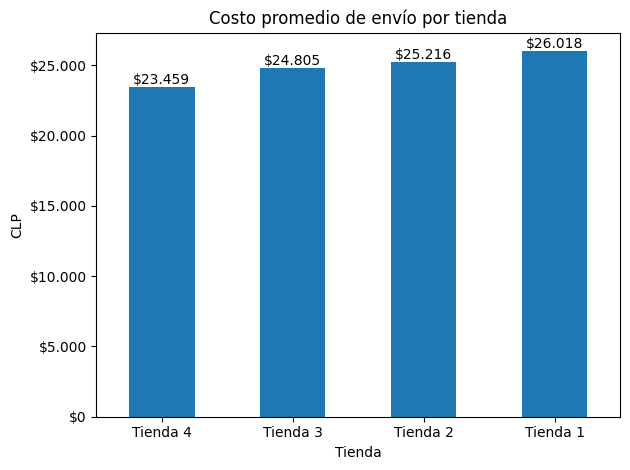

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Si no existe el DF, lo calculamos desde 'stores'
try:
    costos_envio_df
except NameError:
    costos_envio = {
        f'Tienda {i}': df['Costo de envío'].mean()
        for i, df in enumerate(stores, start=1)
    }
    costos_envio_df = pd.DataFrame.from_dict(
        costos_envio, orient='index', columns=['Costo_Envio_Promedio']
    ).sort_values('Costo_Envio_Promedio')

# Formateador CLP
def clp_fmt(x, pos=None):
    try:
        return "$" + f"{int(x):,}".replace(",", ".")
    except Exception:
        return x

fig, ax = plt.subplots()
costos_envio_df.plot(kind='bar', y='Costo_Envio_Promedio', legend=False, ax=ax)

ax.set_title('Costo promedio de envío por tienda')
ax.set_xlabel('Tienda')
ax.set_ylabel('CLP')
ax.set_xticklabels(costos_envio_df.index, rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(clp_fmt))

# Etiquetas arriba de cada barra
for container in ax.containers:
    labels = [clp_fmt(v) for v in container.datavalues]
    ax.bar_label(container, labels=labels)

plt.tight_layout()
plt.show()


## 8) Todas las visualizaciones agrupadas al final

<Figure size 640x480 with 0 Axes>

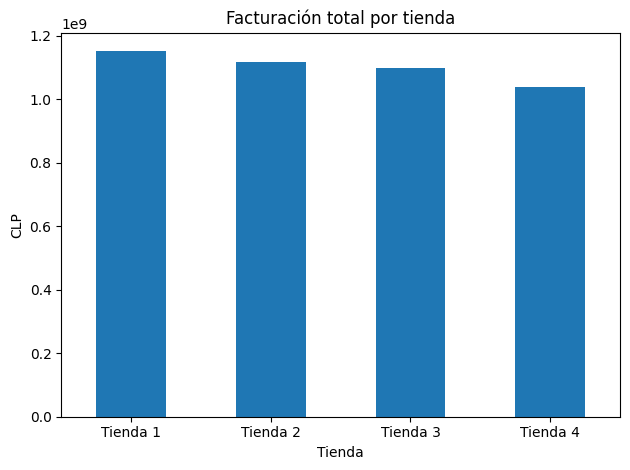

<Figure size 640x480 with 0 Axes>

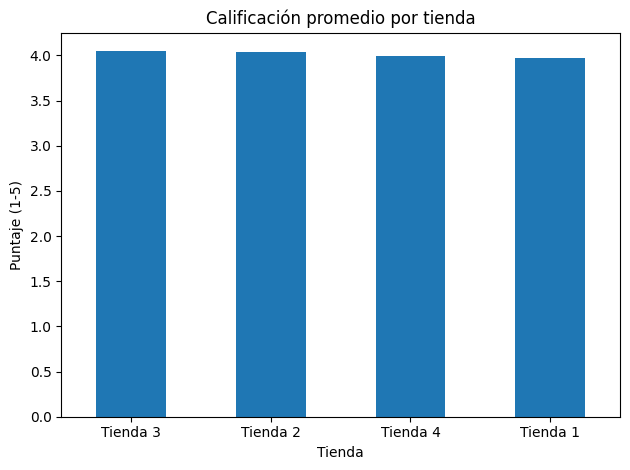

<Figure size 640x480 with 0 Axes>

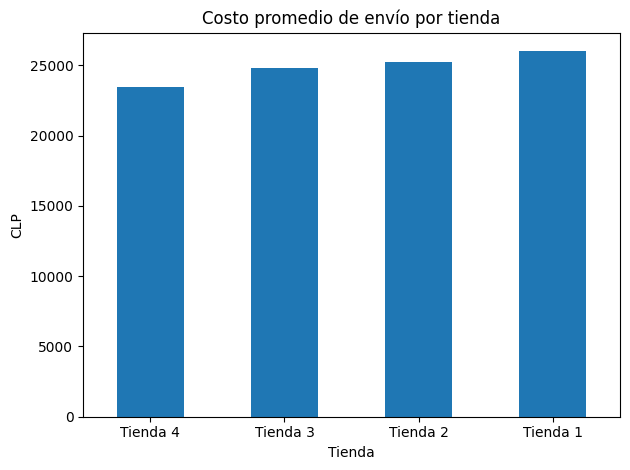

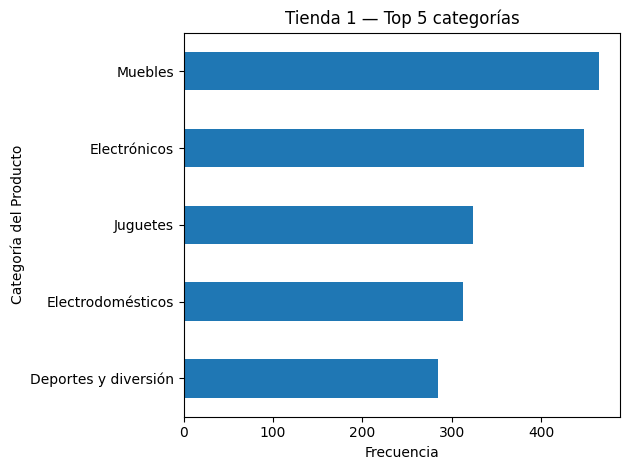

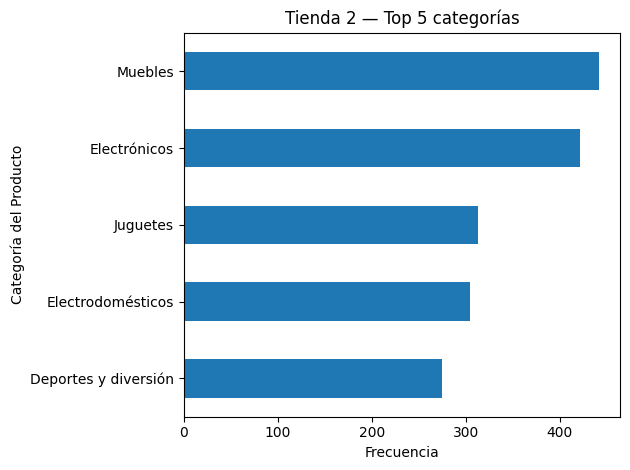

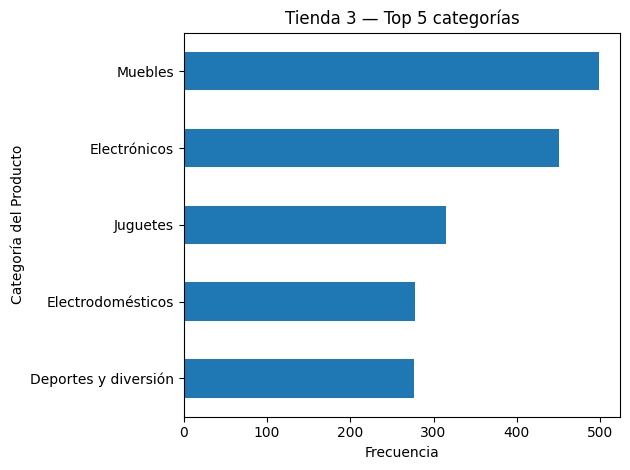

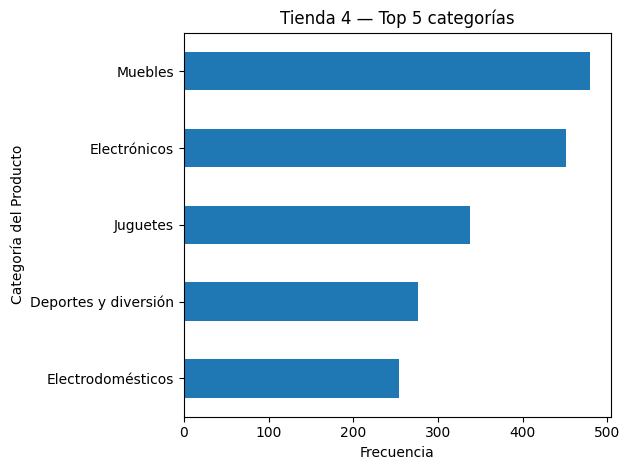

In [ ]:

# 8.1 Facturación por tienda (barras)
plt.figure()
facturacion_df.plot(kind='bar', legend=False)
plt.title('Facturación total por tienda')
plt.ylabel('CLP')
plt.xlabel('Tienda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.2 Calificación promedio por tienda (barras)
plt.figure()
promedios_calificacion_df.plot(kind='bar', legend=False)
plt.title('Calificación promedio por tienda')
plt.ylabel('Puntaje (1-5)')
plt.xlabel('Tienda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.3 Costo promedio de envío por tienda (barras)
plt.figure()
costos_envio_df.plot(kind='bar', legend=False)
plt.title('Costo promedio de envío por tienda')
plt.ylabel('CLP')
plt.xlabel('Tienda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.4 Categorías más populares (gráfico de barras por tienda)
for i, df in enumerate(stores, start=1):
    plt.figure()
    df['Categoría del Producto'].value_counts().head(5).sort_values().plot(kind='barh', legend=False)
    plt.title(f'Tienda {i} — Top 5 categorías')
    plt.xlabel('Frecuencia')
    plt.tight_layout()
    plt.show()


## 9) Conclusión y recomendación inicial

In [ ]:

# Heurística simple para priorizar una recomendación:
# - Menor facturación = peor desempeño comercial
# - Menor calificación promedio = menor satisfacción
# - Mayor costo de envío = menor eficiencia logística
#
# Se normalizan los indicadores y se construye un score conjunto donde
# un valor MÁS ALTO indica 'candidata a vender'.
from sklearn.preprocessing import MinMaxScaler

rank_df = pd.concat([
    facturacion_df.rename(columns={'Facturación_Total':'facturacion'}),
    promedios_calificacion_df.rename(columns={'Calificación_Promedio':'rating'}),
    costos_envio_df.rename(columns={'Costo_Envio_Promedio':'shipping_cost'})
], axis=1)

# Normalización
scaler = MinMaxScaler()
norm = pd.DataFrame(
    scaler.fit_transform(rank_df[['facturacion','rating','shipping_cost']]),
    index=rank_df.index,
    columns=['facturacion_norm','rating_norm','shipping_cost_norm']
)

# Queremos penalizar baja facturación y baja calificación, y penalizar alto costo de envío.
# Para facturación y rating, usamos (1 - valor_normalizado) para que "peor" sea mayor.
# Para shipping_cost, usamos el valor normalizado directamente (más alto = peor).
rank_df['score_vender'] = (1 - norm['facturacion_norm'])*0.45 + (1 - norm['rating_norm'])*0.35 + (norm['shipping_cost_norm'])*0.20
rank_df.sort_values('score_vender', ascending=False, inplace=True)
rank_df


,facturacion,rating,shipping_cost,score_vender
Tienda 4,1.038376e+09,3.995759,23459.457167,0.706814
Tienda 1,1.150880e+09,3.976685,26018.609580,0.550000
Tienda 2,1.116344e+09,4.037304,25216.235693,0.329282
Tienda 3,1.098020e+09,4.048326,24805.680373,0.316643


### > **Interpretación:** La tienda con `score_vender` más alto es la candidata **más fuerte** para ser vendida, pues combina menor desempeño comercial, menor satisfacción y/o mayor costo logístico. Aun así, **me permito sugerir**: complementar con variables estratégicas (contratos de arriendo, proyección de mercado, ubicación, personal, etc.) esta decisión.

# 🎓 ENTREGA OFICIAL (1–5)

> Orden solicitado por el desafío. Cada punto es idempotente, usa carga por **URL**, genera tablas formateadas y evidencia en `outputs/`. 

## 0) Utilidades y carga por URL (idempotente)

In [ ]:

# URLs oficiales
url1 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

import pandas as pd, os, unicodedata
from IPython.display import display
os.makedirs("outputs", exist_ok=True)

# Carga idempotente
try:
    tienda, tienda2, tienda3, tienda4  # type: ignore
except NameError:
    tienda  = pd.read_csv(url1)
    tienda2 = pd.read_csv(url2)
    tienda3 = pd.read_csv(url3)
    tienda4 = pd.read_csv(url4)

# helpers de formato
def _miles(x):  # 1.234.567
    try:
        return f"{int(round(x)):,}".replace(",", ".")
    except Exception:
        return x

def _clp(x):    # $1.234.567
    try:
        return "$" + _miles(x)
    except Exception:
        return x


## 1) Análisis de facturación

In [ ]:

import numpy as np
def analisis_facturacion(df):
    total = pd.to_numeric(df['Precio'], errors='coerce').sum(skipna=True)
    n_ventas = pd.to_numeric(df['Precio'], errors='coerce').notna().sum()
    ticket = total / n_ventas if n_ventas else np.nan
    return total, n_ventas, ticket

rows = []
for nombre, dfx in {"Tienda 1":tienda, "Tienda 2":tienda2, "Tienda 3":tienda3, "Tienda 4":tienda4}.items():
    total, n, ticket = analisis_facturacion(dfx)
    rows.append({"Tienda":nombre, "Facturacion_Total": total, "N_Ventas": n, "Ticket_Promedio": ticket})

resumen_facturacion = (pd.DataFrame(rows)
                       .sort_values("Facturacion_Total", ascending=False)
                       .reset_index(drop=True))

# Mostrar SOLO tabla formateada
display(
    resumen_facturacion
      .assign(Facturacion_Total=lambda d: d["Facturacion_Total"].round(0).map(_clp),
              N_Ventas=lambda d: d["N_Ventas"].round(0).map(_miles),
              Ticket_Promedio=lambda d: d["Ticket_Promedio"].round(0).map(_clp))
)

# Evidencia CSV + gráfico
resumen_facturacion.to_csv("outputs/facturacion_total.csv", index=False)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def clp_fmt(x, pos=None):
    try: return "$" + f"{int(x):,}".replace(",", ".")
    except: return x

fig, ax = plt.subplots()
(resumen_facturacion.sort_values('Facturacion_Total', ascending=False)
 .plot(kind='bar', x='Tienda', y='Facturacion_Total', legend=False, ax=ax))
ax.set_title('Facturación total por tienda')
ax.set_xlabel('Tienda'); ax.set_ylabel('CLP')
ax.yaxis.set_major_formatter(FuncFormatter(clp_fmt))
ax.set_xticklabels(resumen_facturacion['Tienda'], rotation=0)
for c in ax.containers: ax.bar_label(c, labels=[clp_fmt(v) for v in c.datavalues])
plt.tight_layout(); plt.savefig("outputs/facturacion_total.png", bbox_inches="tight"); plt.show()


## 2) Ventas por categoría (Top 5 por tienda)

In [ ]:

import matplotlib.pyplot as plt
from collections import OrderedDict

stores = [tienda, tienda2, tienda3, tienda4]

# Consolidado conteos Top 5 por tienda
cat_tables = []
for i, df in enumerate(stores, start=1):
    top5 = (df['Categoría del Producto'].astype(str).str.strip().value_counts().head(5))
    cat_tables.append(top5.rename(f"Tienda {i}"))

categorias_consolidado = pd.concat(cat_tables, axis=1).fillna(0).astype(int)
display(categorias_consolidado)
categorias_consolidado.to_csv("outputs/categorias_top5_consolidado.csv")

# Gráfico por tienda (PNG) con etiquetas fuera
from matplotlib.ticker import FuncFormatter
for i, df in enumerate(stores, start=1):
    top5 = (df['Categoría del Producto'].astype(str).str.strip().value_counts().head(5).sort_values())
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.barh(top5.index, top5.values)
    ax.set_title(f"Tienda {i} — Top 5 categorías"); ax.set_xlabel("Número de ventas"); ax.set_ylabel("Categoría")
    xmax = top5.values.max()*1.15 if len(top5) else 1; ax.set_xlim(0, xmax)
    for bar, val in zip(bars, top5.values): ax.text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    plt.tight_layout(); plt.savefig(f"outputs/tienda_{i}_categorias_top5.png", bbox_inches="tight"); plt.show()


## 3) Calificación promedio de la tienda

In [ ]:

promedios = []
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    prom = pd.to_numeric(df['Calificación'], errors='coerce').mean(skipna=True)
    promedios.append({"Tienda": f"Tienda {i}", "Calificacion_Promedio": prom})

promedios_calificacion = (pd.DataFrame(promedios)
                          .sort_values('Calificacion_Promedio', ascending=False)
                          .reset_index(drop=True))
display(promedios_calificacion)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots()
promedios_calificacion.plot(kind='bar', x='Tienda', y='Calificacion_Promedio', legend=False, ax=ax)
ax.set_title('Calificación promedio por tienda (1–5)'); ax.set_xlabel('Tienda'); ax.set_ylabel('Puntaje')
ax.set_ylim(0,5); ax.set_xticklabels(promedios_calificacion['Tienda'], rotation=0); ax.yaxis.set_major_locator(MultipleLocator(0.5))
for c in ax.containers: ax.bar_label(c, fmt='%.2f')
plt.tight_layout(); plt.savefig("outputs/calificacion_promedio.png", bbox_inches="tight"); plt.show()

promedios_calificacion.to_csv("outputs/promedios_calificacion.csv", index=False)


## 4) Productos más y menos vendidos (Top/Bottom 5)

In [ ]:

import matplotlib.pyplot as plt, os
os.makedirs("outputs", exist_ok=True)

def top_bottom(df, k=5):
    vc = df['Producto'].astype(str).str.strip().value_counts()
    k = min(k, len(vc))
    topk = vc.head(k).sort_values()
    bottomk = vc.sort_values().head(k)
    return topk, bottomk

# Por tienda: figura con 2 subplots (Top/Bottom)
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    top5, bottom5 = top_bottom(df, 5)
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].barh(top5.index, top5.values); axes[0].set_title(f"Tienda {i} — Top {len(top5)}"); axes[0].set_xlabel("Frecuencia")
    xmax = top5.values.max()*1.15 if len(top5) else 1; axes[0].set_xlim(0, xmax)
    for bar,val in zip(axes[0].containers[0], top5.values): axes[0].text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    axes[1].barh(bottom5.index, bottom5.values); axes[1].set_title(f"Tienda {i} — Bottom {len(bottom5)}"); axes[1].set_xlabel("Frecuencia")
    xb = bottom5.values.max()*1.15 if len(bottom5) else 1; axes[1].set_xlim(0, xb)
    for bar,val in zip(axes[1].containers[0], bottom5.values): axes[1].text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    plt.tight_layout(); plt.savefig(f"outputs/tienda_{i}_productos_top_bottom.png", bbox_inches="tight"); plt.show()


## 5) Costo promedio de envío por tienda

In [ ]:

costos = []
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    prom_env = pd.to_numeric(df['Costo de envío'], errors='coerce').mean(skipna=True)
    costos.append({"Tienda": f"Tienda {i}", "Costo_Envio_Promedio": prom_env})

costos_envio = (pd.DataFrame(costos)
                .sort_values('Costo_Envio_Promedio')
                .reset_index(drop=True))
display(costos_envio)

# gráfico
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def clp_fmt(x, pos=None):
    try: return "$" + f"{int(x):,}".replace(",", ".")
    except: return x

fig, ax = plt.subplots()
(costos_envio.sort_values('Costo_Envio_Promedio')
 .plot(kind='barh', x='Tienda', y='Costo_Envio_Promedio', legend=False, ax=ax))
ax.set_title('Costo promedio de envío por tienda'); ax.set_xlabel('CLP'); ax.set_ylabel('Tienda')
ax.xaxis.set_major_formatter(FuncFormatter(clp_fmt))
for c in ax.containers: ax.bar_label(c, labels=[clp_fmt(v) for v in c.datavalues], label_type='edge', padding=3)
plt.tight_layout(); plt.savefig("outputs/costo_envio_promedio.png", bbox_inches="tight"); plt.show()

costos_envio.to_csv("outputs/costo_envio_promedio.csv", index=False)


## ✅ Conclusión y recomendación (breve)

**Criterios para decidir la tienda candidata a vender**  
1) Menor **facturación** y **ticket** (desempeño comercial).  
2) Menor **calificación** (satisfacción/retención).  
3) Mayor **costo de envío** (eficiencia logística).  

> La interpretación final está en el README y puede ampliarse con variables cualitativas (contratos, ubicación, staff, proyección).  
> En el ANEXO se incluye un *score* opcional que integra estas dimensiones para priorizar la decisión.